In [ ]:
import os, glob, shutil
import gdown
import zipfile

import xml.etree.ElementTree as ET

import random

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle, Polygon

# Data downloading and unboxing + filesystem constants

In [ ]:
def download_data_from_gd(url, quiet=False):
  gdown.download_folder(url, quiet=quiet)

In [ ]:
url = 'https://drive.google.com/drive/folders/1hY_tJNh7azAzc6OxyTEAjjz3UxtzhSeO'

working_dir = '/content'
base_data_path = os.path.join(working_dir,'Annotated Images')

imagenet_dir = os.path.join(base_data_path,'Dataset_ImageNet')
no_label_dir = os.path.join(imagenet_dir,'no_label')

segmentation_dir = os.path.join(base_data_path,'Dataset_SegmentationMask')
classes_txt = os.path.join(segmentation_dir, 'labelmap.txt')
segmentation_list_txt = os.path.join(segmentation_dir, 'ImageSets', 'Segmentation','default.txt')
segmentation_images = os.path.join(segmentation_dir, 'JPEGImages')
segmentation_mask_class = os.path.join(segmentation_dir, 'SegmentationClass')
segmentation_mask_obj = os.path.join(segmentation_dir, 'SegmentationObject')

cvat_dir = os.path.join(base_data_path,'Dataset_CVAT')
cvat_xml = os.path.join(cvat_dir, 'annotations.xml')
cvat_images = os.path.join(cvat_dir, 'images','default')

yolo_dir = os.path.join(base_data_path,'Dataset_YOLO')
yolo_names = os.path.join(yolo_dir, 'obj.names')
yolo_train_data = os.path.join(yolo_dir, 'obj_train_data')
yolo_train_txt = os.path.join(yolo_dir, 'train.txt')

In [ ]:
if os.path.exists(base_data_path):
  print('data exists')
else:
  download_data_from_gd(url)
  for f in os.listdir(base_data_path):
    if f.endswith('.zip'):
      subdir_path = os.path.join(base_data_path, f[:-4])
      os.mkdir(subdir_path)
      with zipfile.ZipFile(os.path.join(base_data_path, f), 'r') as zipp:
        zipp.extractall(path = subdir_path)
  print('data loaded')

Retrieving folder contents


Processing file 1oEtl3FA7HLnG_JESJ7Bx4mMQYwDgQHnG Dataset_CVAT.zip
Processing file 1QmyWKuCYtuB6l3x4oxjZ7QzEWNirFmO8 Dataset_description.txt
Processing file 1D8dr6eJ8pnj3SAkCWgvUkdVrpEbWVO-n Dataset_ImageNet.zip
Processing file 12pzi5gLAQkts_2ihZ17JKwkDqq-wErAU Dataset_SegmentationMask.zip
Processing file 1HU66YH7iAB-4Kh9j6heglnFdZoX49TOq Dataset_YOLO.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1oEtl3FA7HLnG_JESJ7Bx4mMQYwDgQHnG
From (redirected): https://drive.google.com/uc?id=1oEtl3FA7HLnG_JESJ7Bx4mMQYwDgQHnG&confirm=t&uuid=b756d0f8-a04b-4106-a414-e2b194a7fc85
To: /content/Annotated Images/Dataset_CVAT.zip
100%|██████████| 846M/846M [00:12<00:00, 67.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QmyWKuCYtuB6l3x4oxjZ7QzEWNirFmO8
To: /content/Annotated Images/Dataset_description.txt
100%|██████████| 1.04k/1.04k [00:00<00:00, 2.61MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1D8dr6eJ8pnj3SAkCWgvUkdVrpEbWVO-n
From (redirected): https://drive.google.com/uc?id=1D8dr6eJ8pnj3SAkCWgvUkdVrpEbWVO-n&confirm=t&uuid=40abcfb7-ea27-40bd-b0c5-1faf52c84678
To: /content/Annotated Images/Dataset_ImageNet.zip
100%|██████████| 843M/843M [00:07<00:00, 114MB/s]
Downloading...
From (original): https

data loaded


# EDA

## general funcs and consts

In [ ]:
class_cmap_int = {}
with open(classes_txt, 'r') as ctxt:
  for l in ctxt:
    if not l.startswith('#'):
      sp = l.split(':')
      class_cmap_int[sp[0]]=(tuple(int(x) for x in sp[1].split(',')))
class_cmap = {k:tuple(x/255 for x in class_cmap_int[k]) for k in class_cmap_int}

In [ ]:
def print_class_cmap(class_cmap):
  for k in class_cmap:
    print('\033[38;2;%d;%d;%dm'%class_cmap[k], k)

In [ ]:
class_list = []
with open(yolo_names, 'r') as yn:
  class_list = [n[:-1] for n in yn]
class_list

['Other', 'Building', 'Damage', 'Broken Window', 'Roof', 'Damaged roof']

## no_label

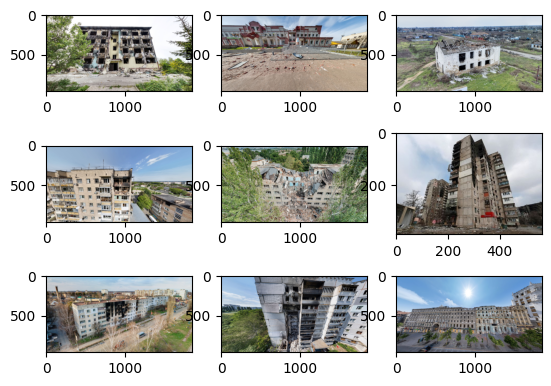

In [ ]:
plot_shape=(3,3)
limit=plot_shape[0]*plot_shape[1]
f, axes = plt.subplots(plot_shape[0], plot_shape[1])
for f in os.listdir(no_label_dir):
  limit -= 1
  axes[limit//plot_shape[1],limit%plot_shape[1]].imshow(mpimg.imread(os.path.join(no_label_dir, f)))
  if limit==0:
    break

## CVAT

In [ ]:
tree = ET.parse(cvat_xml)
tree_r = tree.getroot()

In [ ]:
def plot_cvat_img(tree_node, img_dir, axis):
  axis.imshow(mpimg.imread(os.path.join(img_dir, tree_node.attrib['name'])))
  label_color_map = class_cmap.copy()
  for n in tree_node:
    if n.tag == 'box':
      if n.attrib['label'] not in label_color_map:
        label_color_map[n.attrib['label']] = (random.random(), random.random(), random.random())
      color = label_color_map[n.attrib['label']]
      rect = Rectangle((float(n.attrib['xtl']),float(n.attrib['ytl'])),float(n.attrib['xbr'])-float(n.attrib['xtl']),float(n.attrib['ybr'])-float(n.attrib['ytl']), fill=True, alpha=0.5, color=color)
      axis.add_patch(rect)
    elif n.tag == 'polygon':
      if n.attrib['label'] not in label_color_map:
        label_color_map[n.attrib['label']] = (random.random(), random.random(), random.random())
      color = label_color_map[n.attrib['label']]
      dotlist = [(s.split(',')[0], s.split(',')[1]) for s in n.attrib['points'].split(';')]
      poly = Polygon(dotlist, fill=True, alpha=0.5, color=color)
      axis.add_patch(poly)

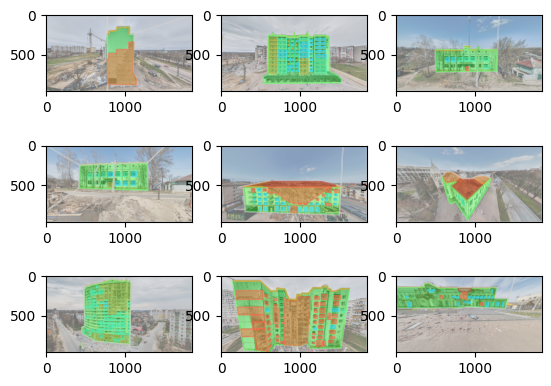

In [ ]:
plot_shape=(3,3)
f, axes = plt.subplots(plot_shape[0], plot_shape[1])
for i in range(plot_shape[0]*plot_shape[1]):
  plot_cvat_img(tree_r[i+2], cvat_images, axes[i//plot_shape[1],i%plot_shape[1]])

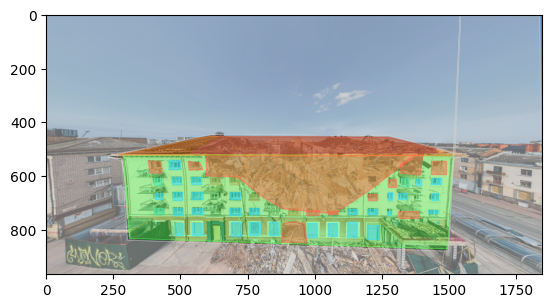

In [ ]:
plot_cvat_img(tree_r[6], cvat_images, plt.gca())

In [ ]:
def plot_cvat_img_layers(tree_node, img_dir):
  f, axes = plt.subplots(7,1)
  for a in axes:
    a.imshow(mpimg.imread(os.path.join(img_dir, tree_node.attrib['name'])))
  for n in tree_node:
    if n.tag == 'box':
      class_n = class_list.index(n.attrib['label'])
      color = class_cmap[n.attrib['label']]
      rect = Rectangle((float(n.attrib['xtl']),float(n.attrib['ytl'])),float(n.attrib['xbr'])-float(n.attrib['xtl']),float(n.attrib['ybr'])-float(n.attrib['ytl']), fill=True, alpha=0.5, color=color)
      axes[class_n].add_patch(rect)
    elif n.tag == 'polygon':
      class_n = class_list.index(n.attrib['label'])
      color = class_cmap[n.attrib['label']]
      dotlist = [(s.split(',')[0], s.split(',')[1]) for s in n.attrib['points'].split(';')]
      poly = Polygon(dotlist, fill=True, alpha=0.5, color=color)
      axes[class_n].add_patch(poly)

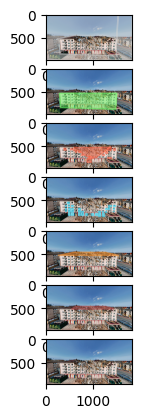

In [ ]:
plot_cvat_img_layers(tree_r[6], cvat_images)

In [ ]:
def plot_cvat_img_one_layer(tree_node, img_dir, class_name, color='red'):
  plt.imshow(mpimg.imread(os.path.join(img_dir, tree_node.attrib['name'])))
  plt.title(class_name)
  for n in tree_node:
    if n.tag == 'box':
      if n.attrib['label'] == class_name:
        class_n = class_list.index(n.attrib['label'])
        if color is None: color = class_cmap[n.attrib['label']]
        rect = Rectangle((float(n.attrib['xtl']),float(n.attrib['ytl'])),float(n.attrib['xbr'])-float(n.attrib['xtl']),float(n.attrib['ybr'])-float(n.attrib['ytl']), fill=True, alpha=0.5, color=color)
        plt.gca().add_patch(rect)
    elif n.tag == 'polygon':
      if n.attrib['label'] == class_name:
        class_n = class_list.index(n.attrib['label'])
        if color is None: color = class_cmap[n.attrib['label']]
        dotlist = [(s.split(',')[0], s.split(',')[1]) for s in n.attrib['points'].split(';')]
        poly = Polygon(dotlist, fill=True, alpha=0.5, color=color)
        plt.gca().add_patch(poly)

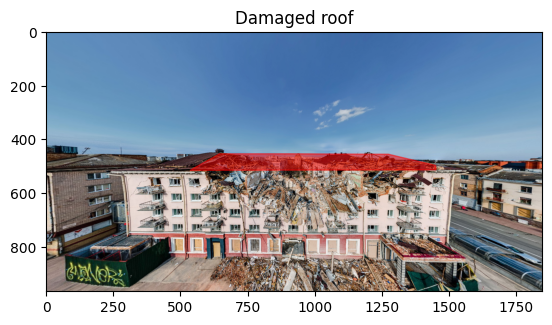

In [ ]:
plot_cvat_img_one_layer(tree_r[6], cvat_images, class_list[5])

In [ ]:
print_class_cmap(class_cmap_int)

 Broken Window
 Building
 Damage
 Damaged roof
 Other
 Roof
 background


## YOLO

In [ ]:
def plot_yolo(img_dir, img_name, boxes, axis):
  im=mpimg.imread(os.path.join(img_dir, img_name))
  axis.imshow(im)
  ims = im.shape
  for b in boxes:
    color = class_cmap[class_list[b[0]]]
    rect = Rectangle(((b[1][0]-b[1][2]/2)*ims[1],(b[1][1]-b[1][3]/2)*ims[0]),b[1][2]*ims[1],b[1][3]*ims[0],color=color,fill=True, alpha=0.5)
    axis.add_patch(rect)

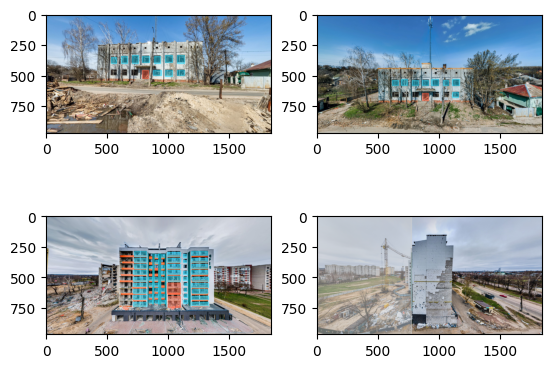

In [ ]:
plot_shape=(2,2)
limit=plot_shape[0]*plot_shape[1]
_, axes = plt.subplots(plot_shape[0], plot_shape[1])
with open(yolo_train_txt, 'r') as yt:
  for l in yt:
    img_name = l.split('/')[-1][:-1]
    with open(os.path.join(yolo_train_data, img_name.split('.')[0]+'.txt'), 'r') as f:
      boxes = [l.split(' ') for l in f]
      boxes = [[int(sp[0]), [float(sp[i]) for i in range(1,5)]] for sp in boxes]
      if len(boxes) > 0:
        limit -= 1
        plot_yolo(yolo_train_data, img_name, boxes, axes[limit//plot_shape[1], limit%plot_shape[1]])
        if limit==0:
          break

In [ ]:
yolo_num=0
yolo_text_num=0
with open(yolo_train_txt, 'r') as yt:
  for l in yt:
    yolo_num+=1
    img_name = l.split('/')[-1][:-1]
    if os.path.getsize(os.path.join(yolo_train_data, img_name.split('.')[0]+'.txt'))>0:
      yolo_text_num+=1
print('all data:', yolo_num, '\ndata with boxes:', yolo_text_num)

all data: 290 
data with boxes: 28


## Segmentation

In [ ]:
def plot_segmentation(img_path, label_path, axis):
  axis.imshow(mpimg.imread(img_path))
  axis.imshow(mpimg.imread(label_path), alpha=0.5)

In [ ]:
def plot_segmentation_several(by_class=True):
  plot_shape=(2,2)
  limit=plot_shape[0]*plot_shape[1]
  _, axes = plt.subplots(plot_shape[0], plot_shape[1])
  with open(segmentation_list_txt, 'r') as f:
    for l in f:
      img_path = glob.glob(os.path.join(segmentation_images, l[:-1]+'.*'))[0]
      label_path = os.path.join(segmentation_mask_class if by_class else segmentation_mask_obj, l[:-1]+'.png')
      limit -= 1
      plot_segmentation(img_path, label_path, axes[limit//plot_shape[1], limit%plot_shape[1]])
      if limit==0:
        break

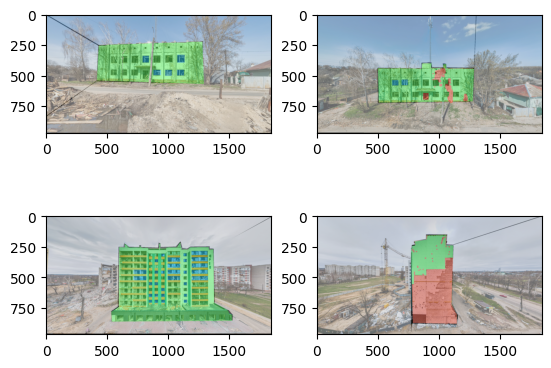

In [ ]:
plot_segmentation_several()

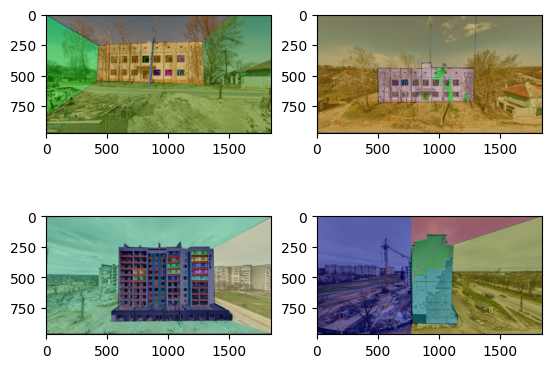

In [ ]:
plot_segmentation_several(False)

# YOLO-World

## Data preparation

In [ ]:
yoloworld_data_base = os.path.join(working_dir, 'yoloworld_data')
yoloworld_dataset = os.path.join(yoloworld_data_base, 'dataset')
yoloworld_train = os.path.join(yoloworld_dataset, 'train')
yoloworld_train_img = os.path.join(yoloworld_train, 'images')
yoloworld_train_labels = os.path.join(yoloworld_train, 'labels')
yoloworld_val = os.path.join(yoloworld_dataset, 'val')
yoloworld_val_img = os.path.join(yoloworld_val, 'images')
yoloworld_val_labels = os.path.join(yoloworld_val, 'labels')

In [ ]:
os.mkdir(yoloworld_data_base)
os.mkdir(yoloworld_dataset)
os.mkdir(yoloworld_train)
os.mkdir(yoloworld_train_img)
os.mkdir(yoloworld_train_labels)
os.mkdir(yoloworld_val)
os.mkdir(yoloworld_val_img)
os.mkdir(yoloworld_val_labels)

In [ ]:
train_c, val_c = train_part, val_part = 27,1
for n in tree_r:
  if n.tag == "image":
    boxes = []
    img = mpimg.imread(os.path.join(cvat_images, n.attrib['name']))
    imshape = img.shape
    for n2 in n:
      x,y,x2,y2=0,0,0,0
      if n2.tag == 'box':
        x,y,x2,y2 = float(n2.attrib['xtl']),float(n2.attrib['ytl']),float(n2.attrib['xbr']),float(n2.attrib['ybr'])
      elif n2.tag == 'polygon':
        dotlist = [(s.split(',')[0], s.split(',')[1]) for s in n2.attrib['points'].split(';')]
        x_list = [float(d[0]) for d in dotlist]
        y_list = [float(d[1]) for d in dotlist]
        x,y,x2,y2 = min(x_list),min(y_list),max(x_list),max(y_list)
      else:
        continue
      x,y,w,h = (x+x2)/2,(y+y2)/2,x2-x,y2-y
      x/=imshape[1]
      w/=imshape[1]
      y/=imshape[0]
      h/=imshape[0]
      boxes.append([class_list.index(n2.attrib['label']), x, y, w, h])
    label_text = '\n'.join([' '.join(str(x) for x in b) for b in boxes])
    img_name = n.attrib['name']
    txt_name = img_name.split('.')[0]+'.txt'
    if train_c>0 or val_c == 0:
      with open(os.path.join(yoloworld_train_labels, txt_name), 'w') as f:
        f.write(label_text)
      shutil.copy(os.path.join(cvat_images, img_name), yoloworld_train_img)
      train_c -=1
    else:
      with open(os.path.join(yoloworld_val_labels, txt_name), 'w') as f:
        f.write(label_text)
      shutil.copy(os.path.join(cvat_images, img_name), yoloworld_val_img)
      val_c -=1
      if val_c == 0:
        train_c, val_c = train_part, val_part

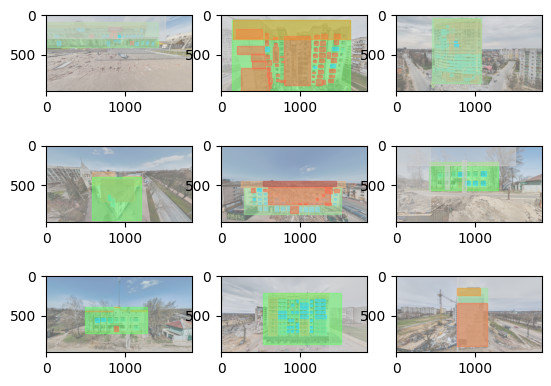

In [ ]:
plot_shape=(3,3)
limit=plot_shape[0]*plot_shape[1]
_, axes = plt.subplots(plot_shape[0], plot_shape[1])
with open(yolo_train_txt, 'r') as yt:
  for l in yt:
    img_name = l.split('/')[-1][:-1]
    with open(os.path.join(yoloworld_train_labels, img_name.split('.')[0]+'.txt'), 'r') as f:
      boxes = [l.split(' ') for l in f]
      boxes = [[int(sp[0]), [float(sp[i]) for i in range(1,5)]] for sp in boxes]
      limit -= 1
      plot_yolo(yoloworld_train_img, img_name, boxes, axes[limit//plot_shape[1], limit%plot_shape[1]])
      if limit==0:
        break

# Roboflow


In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12

In [ ]:
from roboflow import Roboflow
roboflow_api_key = "Secret_key" # @param {type:"string"}
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace("tls-fx17y").project("damaged-building-jytkn")
for i in range(1,4):
  version = project.version(i)
  dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to damaged-building-1 in yolov8:: 100%|██████████| 1296/1296 [00:00<00:00, 1861.60it/s]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to damaged-building-2 in yolov8:: 100%|██████████| 1354/1354 [00:00<00:00, 3146.21it/s]


[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to damaged-building-3 in yolov8:: 100%|██████████| 868/868 [00:00<00:00, 1108.49it/s]


In [ ]:
import os, glob, shutil

import random

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

In [ ]:
working_dir = '/content'
damaged_building_1 = os.path.join(working_dir, 'damaged-building-1')
damaged_building_2 = os.path.join(working_dir, 'damaged-building-2')
damaged_building_3 = os.path.join(working_dir, 'damaged-building-3')

In [ ]:
def plot_yolo(img_dir, img_name, boxes, axis, class_cmap, class_list):
  im=mpimg.imread(os.path.join(img_dir, img_name))
  axis.imshow(im)
  ims = im.shape
  for b in boxes:
    color = class_cmap[class_list[b[0]]]
    rect = Rectangle(((b[1][0]-b[1][2]/2)*ims[1],(b[1][1]-b[1][3]/2)*ims[0]),b[1][2]*ims[1],b[1][3]*ims[0],color=color,fill=True, alpha=0.5)
    axis.add_patch(rect)

In [ ]:
def create_class_cmap(class_list):
  class_cmap={}
  idx=0
  for c in class_list:
    class_cmap[c] = [0,0,0]
    class_cmap[c][idx]=1
    idx+=1
  return class_cmap

In [ ]:
def plot_damaged_building_dataset(version, subdir):
  base_path = os.path.join(working_dir, 'damaged-building-'+str(version))
  data_yaml = os.path.join(base_path, 'data.yaml')
  img_path  = os.path.join(base_path, subdir, 'images')
  label_path  = os.path.join(base_path, subdir, 'labels')
  with open(data_yaml, 'r') as yaml:
    yaml_content = yaml.read()
  class_list = [x[2:] for x in yaml_content.split('\n') if len(x)>0 and x[0]=='-']
  class_cmap = create_class_cmap(class_list)
  plot_shape=(3,3)
  limit=plot_shape[0]*plot_shape[1]
  fig, axes = plt.subplots(plot_shape[0], plot_shape[1])
  for f in os.listdir(label_path):
    img_name = f[:-4]+'.jpg'
    with open(os.path.join(label_path, f), 'r') as f:
      boxes = [l.split(' ') for l in f]
      boxes = [[int(sp[0]), [float(sp[i]) for i in range(1,5)]] for sp in boxes]
      limit -= 1
      plot_yolo(img_path, img_name, boxes, axes[limit//plot_shape[1], limit%plot_shape[1]], class_cmap, class_list)
      if limit==0:
        break
  lp = lambda i: plt.plot([],color=class_cmap[i], ms=5, mec="none", label=i, ls="", marker="o")[0]
  handles = [lp(i) for i in class_list]
  fig.legend(handles=handles, loc='lower center')
  fig.suptitle('version '+str(version))

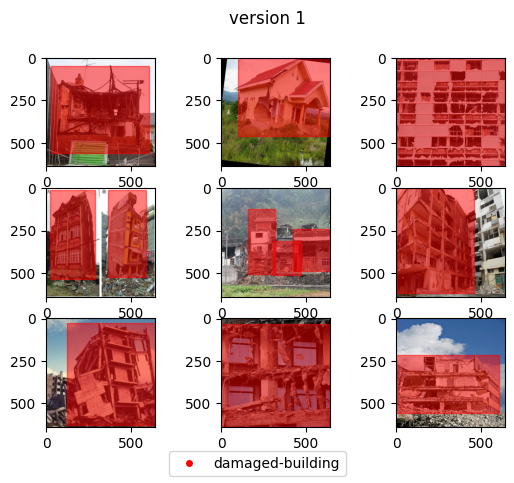

In [ ]:
plot_damaged_building_dataset(1, 'train')

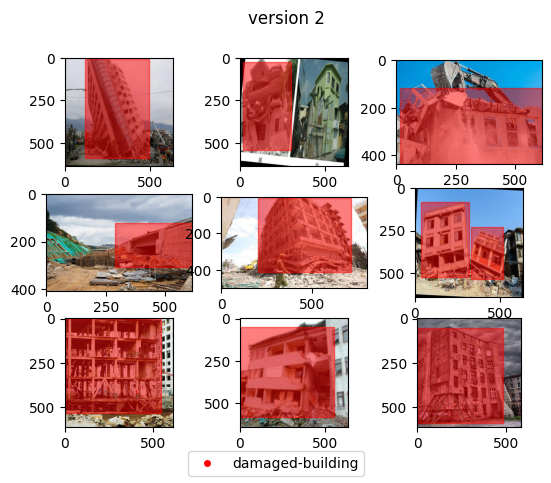

In [ ]:
plot_damaged_building_dataset(2, 'train')

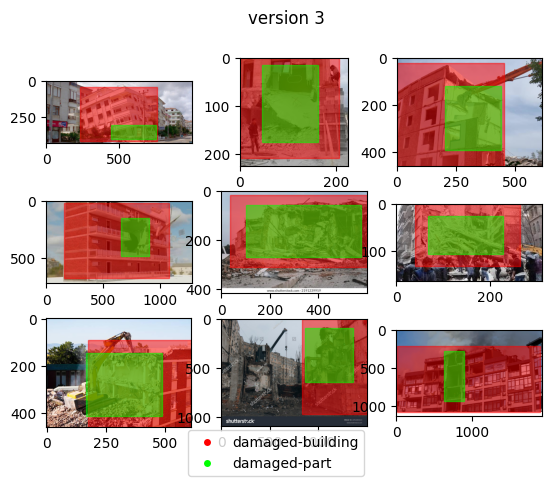

In [ ]:
plot_damaged_building_dataset(3, 'train')